<h1>1. Data Preprocessing</h1>

In [1]:
import pandas as pd
import numpy as np

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
missing_values = ['unknown', 'Unknown',"Penicillin unspecified"]
data = pd.read_csv("delabel_data.csv", na_values = missing_values)
data = data.drop(['ID'], axis = 1)
data = data.drop(['SK_Results'], axis = 1)
data = data.drop(['OC_Results'], axis = 1)
data = data.drop(['Penicillin_allergy_label'], axis = 1)
data = data.dropna(subset = ['Allergy_Results'])
data = data.dropna(thresh = data.shape[1]-3) #filter out all the rows that have more than 3 NaNs
data.shape

(62, 11)

In [65]:
data['Urticaria'] = data.Urticaria.astype(object)
data['Angioedema'] = data.Angioedema.astype(object)
data['Anaphylaxis'] = data.Anaphylaxis.astype(object)
data['Adrenaline_use'] = data.Adrenaline_use.astype(object)
data['ED_presentation'] = data.ED_presentation.astype(object)
data['Allergy_Results'] = data.Allergy_Results.astype(object)
data['React_time'] = data.React_time.astype(object)
data['Latency'] = data.Latency.astype(object)
data.dtypes

Age                float64
Gender              object
Urticaria           object
Angioedema          object
Anaphylaxis         object
Adrenaline_use      object
ED_presentation     object
Latency             object
React_time          object
Treatment           object
Allergy_Results     object
dtype: object

In [66]:
data.head(10)

,Age,Gender,Urticaria,Angioedema,Anaphylaxis,Adrenaline_use,ED_presentation,Latency,React_time,Treatment,Allergy_Results
2,19.0,Female,0,0,0,0,0,1,0,Yes,1
3,41.0,Male,0,1,0,0,0,1,NaN,Yes,0
4,44.0,Male,0,0,0,0,0,1,NaN,NaN,0
7,63.0,Male,0,0,0,0,0,1,1,NaN,0
8,87.0,Female,0,0,0,0,0,1,NaN,NaN,0
10,28.0,Female,0,0,0,0,0,1,NaN,NaN,0
16,14.0,Female,0,0,0,0,0,1,1,NaN,0
17,38.0,Female,0,0,0,0,0,0,1,Yes,1
18,50.0,Female,0,0,0,0,0,1,NaN,NaN,0
19,56.0,Female,1,0,0,0,0,1,1,NaN,1


In [67]:
from sklearn.impute import SimpleImputer

In [68]:
s_imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent', verbose = 0)
data_array = data.values
data_array = s_imputer.fit_transform(data_array)

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
labelencolder = LabelEncoder()
data_array[:,1] = labelencolder .fit_transform(data_array[:,1]) #encode gender
data_array[:,9] = labelencolder .fit_transform(data_array[:,9]) #encode treatment

In [217]:
X = data_array[:,:-1] 
y = data_array[:,-1]
y = y.astype('int')

In [218]:
from sklearn.model_selection import train_test_split

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 0)

<h2> 1.1 Synthetic Minority Oversampling Technique (SMOTE)</h2>

In [74]:
weights = np.linspace(0.6,1,5)
weights

array([0.6, 0.7, 0.8, 0.9, 1. ])

In [75]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [76]:
sm = SMOTE(random_state=42, sampling_strategy = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [77]:
unique, count = np.unique(y_train, return_counts = True)
y_train_smote_value_count = {k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 40, 1: 9}

In [78]:
unique, count = np.unique(y_train_res, return_counts = True)
y_train_smote_value_count = {k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 40, 1: 40}

In [79]:
X_res, y_res = sm.fit_sample(X, y)

In [80]:
unique_1, count_1 = np.unique(y, return_counts = True)
y_train_smote_value_count_1 = {k:v for (k,v) in zip(unique_1, count_1)}
y_train_smote_value_count_1

{0: 51, 1: 11}

In [81]:
unique_1, count_1 = np.unique(y_res, return_counts = True)
y_train_smote_value_count_1 = {k:v for (k,v) in zip(unique_1, count_1)}
y_train_smote_value_count_1

{0: 51, 1: 51}

<h2> 1.2 Feature extraction by using recursive feature elimination</h2>

In [82]:
from sklearn.feature_selection import RFE

In [83]:
def rfe(model):
    rfe = RFE(model,4)
    fit = rfe.fit(X, y)
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))

<h2>1.3 Model performance evaluation</h2>

In [84]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [86]:
def print_report(y_actual, y_pred):

    cnf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cnf_matrix.ravel()
    specificity = tn / (tn+fp)
    auc = roc_auc_score (y_actual, y_pred)
    accuracy = accuracy_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
 
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('F1 score: %.3f'%f1_score(y_test, y_pred, labels=np.unique(y_pred)))
     
    class_name = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_name))
    plt.xticks(tick_marks, class_name)
    plt.yticks(tick_marks, class_name)

    #create heatmap for the confusion matrix
    plot1 = plt.figure(1)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label',fontsize = 'large')
    plt.xlabel('Predicted label',fontsize = 'large')
    ax.xaxis.set_label_position("top")
    
    #plot the ROC
    plot1 = plt.figure(2)
    fpr_train, tpr_train, tresholds_train = roc_curve(y_actual,y_pred)
    plt.plot(fpr_train,tpr_train,'r--', label = 'AUC:%.3f'%auc)
    plt.plot([0,1],[0,1], 'k--') 
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<h1> 2. Train the model </h1>

<h2>2.1 Logistic Regression</h2>

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
logreg_model = LogisticRegression(solver='lbfgs', max_iter=200)
logreg_model.fit(X_train_res,y_train_res)
logreg_y_pred = logreg_model.predict(X_test)

AUC:0.909
Accuracy:0.846
Recall:1.000
Precision:0.500
specificity:0.818
F1 score: 0.667


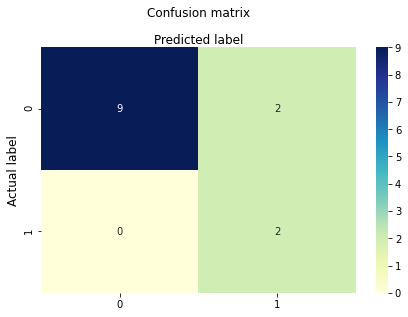

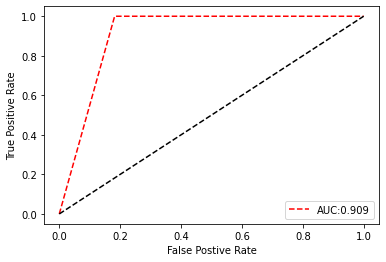

In [89]:
print_report(y_test,logreg_y_pred)

<h3> 2.1.1 logistic regression best 4 features by using rfe</h3>

In [90]:
#Feature Extraction
rfe(logreg_model)
# Best 4 features: 1. gender, 6. ED_presentation, 4 Anaphylaxis, 3. Angioedema,

Num Features: 4
Selected Features: [False  True False  True  True False  True False False False]
Feature Ranking: [7 1 4 1 1 6 1 5 2 3]


<h3> 2.1.2 logistic regression model performance evaluation after the feature selection </h3>

In [91]:
logreg_X_train_new = []
for i in range(len(X_train_res)):
    temp = []
    temp.append(X_train_res[i,1])
    temp.append(X_train_res[i,3])
    temp.append(X_train_res[i,4])
    temp.append(X_train_res[i,6])   
    logreg_X_train_new.append(temp)
    temp = []
    
logreg_X_test_new = []
for i in range(len(X_test)):
    temp = []
    temp.append(X_test[i,1])
    temp.append(X_test[i,3])
    temp.append(X_test[i,4])
    temp.append(X_test[i,6])
    logreg_X_test_new.append(temp)
    temp = []

In [92]:
logreg_model = LogisticRegression(solver='lbfgs', max_iter=200)
logreg_model.fit(logreg_X_train_new,y_train_res)
logreg_y_pred_new = logreg_model.predict(logreg_X_test_new)

AUC:0.955
Accuracy:0.923
Recall:1.000
Precision:0.667
specificity:0.909
F1 score: 0.800


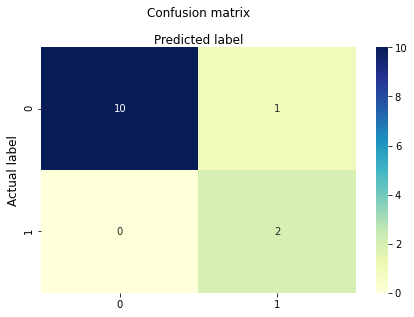

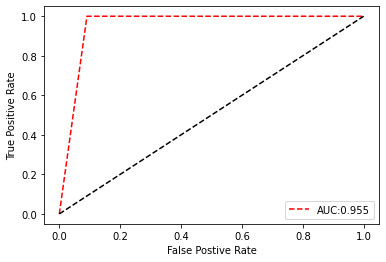

In [93]:
print_report(y_test,logreg_y_pred_new)

<h2>2.2 SVM</h2>

In [94]:
from sklearn import svm

In [95]:
svm_model = svm.SVC(C=1, kernel='linear', degree=3, gamma='scale')
svm_model.fit(X_train_res,y_train_res)
svm_y_pred = svm_model.predict(X_test)

AUC:0.705
Accuracy:0.846
Recall:0.500
Precision:0.500
specificity:0.909
F1 score: 0.500


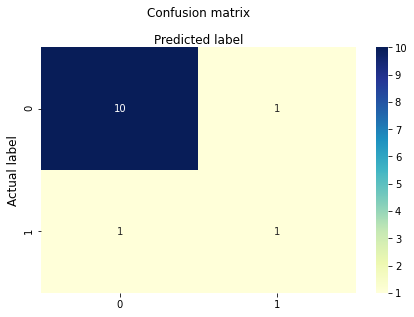

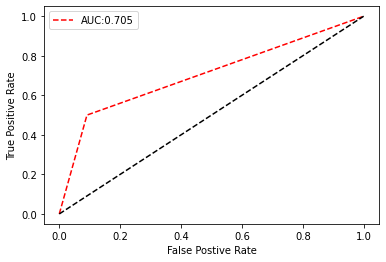

In [96]:
print_report(y_test,svm_y_pred)

<h3> 2.2.1 svm best 4 features by using rfe </h3>

In [97]:
#Feature Extraction
rfe(svm_model)

# Best 4 features: 1 gender, 4 Anaphylaxis, 6 ED_presentation, 7 Latency

Num Features: 4
Selected Features: [False  True False False  True False  True  True False False]
Feature Ranking: [7 1 4 2 1 3 1 1 5 6]


<h3> 2.2.2 svm performance evaluation after the feature selection </h3>

In [188]:
svm_X_train_new = []
for i in range(len(X_train_res)):
    temp = []
    temp.append(X_train_res[i,1])  
    temp.append(X_train_res[i,4])
    temp.append(X_train_res[i,6])
    temp.append(X_train_res[i,7])
    svm_X_train_new.append(temp)
    temp = []
    
svm_X_test_new = []
for i in range(len(X_test)):
    temp = []
    temp.append(X_test[i,1])
    temp.append(X_test[i,4])
    temp.append(X_test[i,6])
    temp.append(X_test[i,7])
    svm_X_test_new.append(temp)
    temp = []

In [189]:
svm_model_new = svm.SVC(C=1, kernel='linear', degree=3, gamma='scale')
svm_model_new.fit(svm_X_train_new,y_train_res)
svm_y_pred_new = svm_model_new.predict(svm_X_test_new)

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
specificity:1.000
F1 score: 1.000


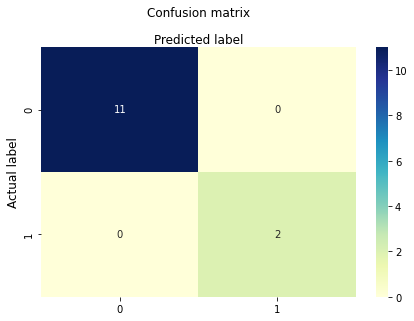

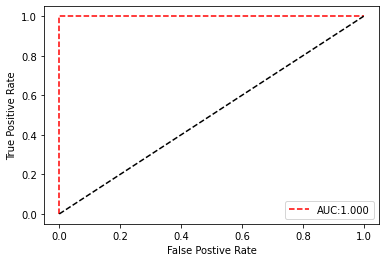

In [190]:
print_report(y_test,svm_y_pred_new)

<h2>2.3 Random Forest</h2>

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier(n_estimators=10, random_state=10)
rf.fit(X_train_res, y_train_res)
rf_y_pred = rf.predict(X_test)

AUC:0.705
Accuracy:0.846
Recall:0.500
Precision:0.500
specificity:0.909
F1 score: 0.500


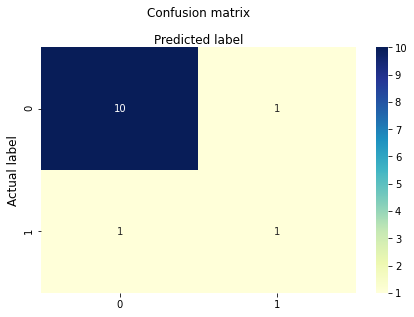

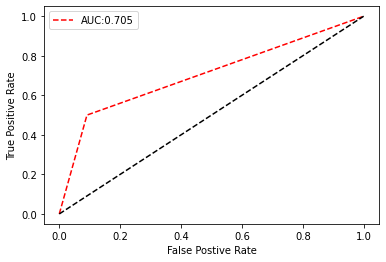

In [192]:
print_report(y_test,rf_y_pred)

<h3> 2.3.1 rf feature extraction </h3>

method 1: rf feature importances

In [193]:
print(rf.feature_importances_) 

[0.20807194 0.07882275 0.08641441 0.06882306 0.01671178 0.0557798
 0.06093253 0.12185412 0.21948386 0.08310576]


,Features,Importances
8,8,0.219484
0,0,0.208072
7,7,0.121854
2,2,0.086414
9,9,0.083106
1,1,0.078823
3,3,0.068823
6,6,0.060933
5,5,0.055780
4,4,0.016712


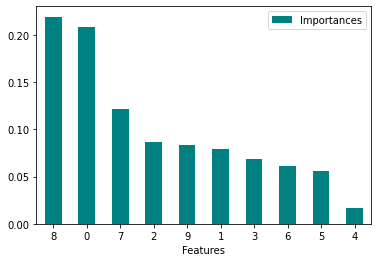

In [194]:
rf_importance = rf.feature_importances_
final_df = pd.DataFrame({"Features": pd.DataFrame(X).columns, "Importances": rf_importance })
final_df.set_index('Importances')

# sort the feature importances in a decending order 
final_df = final_df.sort_values(by = 'Importances', ascending=False)

# plot the features in bars
final_df.plot.bar(x = 'Features', y = 'Importances', color = 'teal', rot = 0)
final_df

# Best 5 features: React_time, age, Latency, Treatment, gender

method 2: recursive feature elimination

In [195]:
rfe(rf)

# Best 4 features: age, Urticaria, ED_presentation, React_time

Num Features: 4
Selected Features: [False False  True  True False  True False False  True False]
Feature Ranking: [4 3 1 1 5 1 2 7 1 6]


<h3> 2.3.2 rf performance evaluation after the feature extraction </h3>

In [200]:
rf_X_train_new = []
for i in range(len(X_train_res)):
    temp = []
    temp.append(X_train_res[i,8])
    temp.append(X_train_res[i,7])
    temp.append(X_train_res[i,6])
    temp.append(X_train_res[i,0])
    temp.append(X_train_res[i,4])
    rf_X_train_new.append(temp)
    temp = []
    
rf_X_test_new = []
for i in range(len(X_test)):
    temp = []
    temp.append(X_test[i,8])
    temp.append(X_test[i,7])
    temp.append(X_test[i,6])
    temp.append(X_test[i,0])
    temp.append(X_test[i,4])
    rf_X_test_new.append(temp)
    temp = []

In [201]:
rf = RandomForestClassifier(n_estimators=10, random_state=10)
rf.fit(rf_X_train_new, y_train_res)
rf_y_pred_new = rf.predict(rf_X_test_new)

AUC:0.705
Accuracy:0.846
Recall:0.500
Precision:0.500
specificity:0.909
F1 score: 0.500


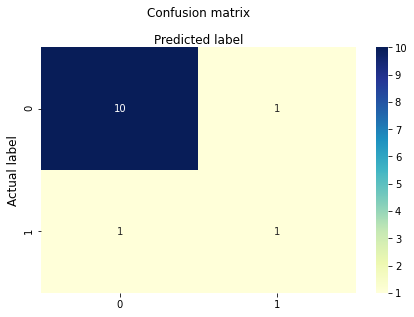

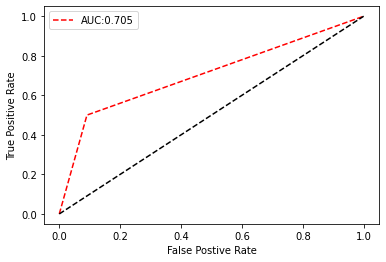

In [202]:
print_report(y_test,rf_y_pred_new)

<h2> 2.4 Neural Networks Classification </h2>

In [203]:
from sklearn.neural_network import MLPClassifier

In [204]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 2), random_state=1)
mlp_clf.fit(X_train_res, y_train_res)
mlp_clf_y_pred = mlp_clf.predict(X_test)

AUC:0.477
Accuracy:0.462
Recall:0.500
Precision:0.143
specificity:0.455
F1 score: 0.222


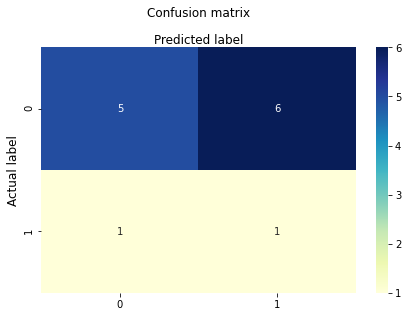

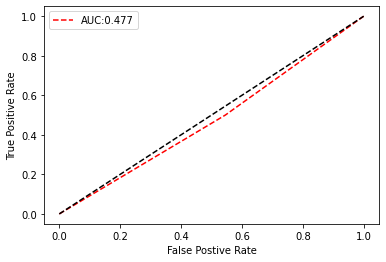

In [205]:
print_report(y_test,mlp_clf_y_pred)

<h1>3. Other Feature Selection methods </h1>

<h2> 3.1 chi-square test </h2>

In [214]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [215]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [220]:
# chi-square test, SelectKBest
chi2_features = SelectKBest(chi2, k=4)
X_kbest_features = chi2_features.fit_transform(X,y)

#reduced features
print('Original feature number:', X.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])
chi2_features.scores_

# Best 5 features: 1. ED_presentation, 2. Anaphylaxis, 3. Treatment, 4. Angioedema/Adrenaline_use

Original feature number: 10
Reduced feature number: 4


array([1.96044895e+00, 2.62518230e+00, 2.61367688e+00, 4.27807487e+00,
       9.27272727e+00, 4.27807487e+00, 9.84076055e+00, 1.97998080e-01,
       1.97998080e-01, 6.71877142e-03])

In [221]:
pipe = Pipeline([
            ("selector",chi2_features),
            ("clf", mlp_clf)
])

pipe.fit(X, y)

Pipeline(steps=[('selector',
                 SelectKBest(k=4, score_func=<function chi2 at 0x135c2b5e0>)),
                ('clf',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(4, 2),
                               random_state=1, solver='lbfgs'))])

In [222]:
pipe.score(X,y)

0.8548387096774194

<h2>3.2 Fisher's Score </h2>

In [223]:
# feature extraction before SMOTE
from skfeature.function.similarity_based import fisher_score

# Calculate the score
ranks = fisher_score.fisher_score(X,y,mode ='rank')
ranks

#Best 5 features: Treatment, React_time, Latency, ED_presentation, age [9,7,6,0,2]

array([3, 5, 4, 6, 8, 7, 2, 1, 9, 0])

In [224]:
# feature extraction after SMOTE

from skfeature.function.similarity_based import fisher_score

# Calculate the score
ranks = fisher_score.fisher_score(X_res,y_res,mode ='rank')
ranks

#Best 5 features: React_time, Latency, ED_presentation, age, Anaphylaxis [8,7,6,0,4]

array([3, 8, 5, 6, 4, 7, 2, 1, 0, 9])

<h1>4. RFE for classification - Automatically select the number of features </h1>

In [225]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [226]:
from numpy import mean
from numpy import std

In [227]:
def get_dataset():
    X, y = X_res, y_res
    return X, y

def get_models():
    models = dict()
    #lr
    rfe = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=200))
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    #svm
    rfe = RFECV(estimator= svm.SVC(C=1, kernel='linear', degree=3, gamma='scale'))
    model = DecisionTreeClassifier()
    models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
    #rf
    rfe = RFECV(estimator= RandomForestClassifier(n_estimators=10, random_state=10))
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = []
    score_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    score_recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    score_precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
    score_f1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    scores.append('Accuracy:%.3f (%.3f)'%(mean(score_accuracy), std(score_accuracy)))
    scores.append('Recall:%.3f (%.3f)'%(mean(score_recall), std(score_recall)))
    scores.append('Presicion:%.3f (%.3f)'%(mean(score_precision), std(score_precision)))
    scores.append('f1:%.3f (%.3f)'%(mean(score_f1), std(score_f1)))
    return scores 

In [228]:
# define dataset 
X_auto, y_auto = get_dataset()

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_auto, y_auto)
    results.extend(scores)
    names.append(name)
    print(name, results) 
    results = list()


lr ['Accuracy:0.830 (0.109)', 'Recall:0.714 (0.199)', 'Presicion:0.951 (0.103)', 'f1:0.796 (0.141)']
svm ['Accuracy:0.863 (0.102)', 'Recall:0.773 (0.158)', 'Presicion:0.964 (0.094)', 'f1:0.844 (0.112)']
rf ['Accuracy:0.841 (0.101)', 'Recall:0.846 (0.179)', 'Presicion:0.841 (0.126)', 'f1:0.836 (0.120)']
